In [1]:

import os

import numpy as np
import pandas as pd
import argparse

from datetime import datetime

from utils.projection import cal_cam_coord
from utils.read_proj_mat import read_projection_matrices
from mrgb_proc import mrgb_proc
from utils.cmb_eval import cmb_eval

import pytz
import yaml
import json

# Set a global time zone: Central Time
CT_time_zone = pytz.timezone('America/Chicago')

def search_files(folder_path, search_text, file_format=".csv"):
    file_names = []
    # Iterate over all files in the folder
    for file_name in os.listdir(folder_path):
        # print(file_name)
        # Check if the file is a text file
        if file_name.endswith(file_format):
            # Check if the search text is present in the file name
            if search_text in file_name:
                file_names.append(file_name)
    return sorted(file_names)

def select_range(timestamps, point1, point2):
    assert point1 != point2, f'Invalid range {point2} = {point1}'
    # print(f'{point1} vs {point2}')
    
    if point1 > point2:
        selected = [value for value in timestamps if point2 <= value < point1]
    else:
        selected = [value for value in timestamps if point1 <= value < point2]
    return selected



print('\nMODALITY: M-RGB (S2) --------------------------------------------')

date = '0725'
behav_list = ['unknown', 'walking', 'standing', 'feed up', 'feed down', 'licking', 'drinking', 'lying']

config = 's2'
moda = 'M-RGB ' + config
config_name = 'config_' + config + '.json'

current_dir = os.getcwd()

# parser = argparse.ArgumentParser(description='Test')
# parser.add_argument('--path_dir', type=str, default=os.path.join(current_dir, 'private', "path.yaml"))
# parser.add_argument('--config_dir', type=str, default=os.path.join(current_dir, 'private', config_name))   
# args = parser.parse_args() 

yaml_dir = os.path.join(current_dir, 'private', "path.yaml")
json_dir = os.path.join(current_dir, 'private', config_name)

with open(yaml_dir, 'r') as file:
    file_dirs = yaml.safe_load(file)
sensor_data_dir = file_dirs['sensor_data_dir']

with open(json_dir, 'r') as f:
    config = json.load(f)

sensor_data_dir = file_dirs['sensor_data_dir']
visual_data_dir = file_dirs['visual_data_dir']
behav_dir = os.path.join(sensor_data_dir, 'behavior_labels', 'individual')
pred_label_dir = os.path.join(visual_data_dir, 'output_labels')
proj_mat_dir = os.path.join(visual_data_dir, 'proj_mat')

# print("proj mat: ", proj_mat_dir)

Proj_cam_list = read_projection_matrices(proj_mat_dir, date)

cam_coord = []
for idx in range(4):
    proj_mat = Proj_cam_list[idx]
    cam_coord.append(cal_cam_coord(proj_mat))
    # print(f"Cam {idx+1} loc: {cal_cam_coord(proj_mat).astype(int)}")
cam_coord = np.asarray(cam_coord).reshape((4,3))

# Read behavior labels
behav_gt_list = []
for cow_id in range(1,17):
    csv_file = f'C{cow_id:02d}_{date}.csv' 
    behav_df = pd.read_csv(os.path.join(behav_dir, csv_file))
    assert np.shape(behav_df)[1] == 3, f'Wrong csv'
    behav_gt_list.append(behav_df)
assert len(behav_gt_list) == 16, f'Missing behavior ground truth'

# Extract timestamps from txt labels 
temp_list = []
for i in range(1,5):
    cam_name = f"cam_{i:d}"
    folder_path = os.path.join(pred_label_dir, date, cam_name)
    # print(folder_path)
    filename_list = search_files(folder_path, search_text='_', file_format=".txt")
    for single_filename in filename_list:
        temp_list.append(int(single_filename[0:10]))
temp_list = np.asarray(temp_list)
combined_timestamps = list(np.unique(temp_list))
combined_timestamps.sort() # must sort here
print('\nTotal # of timestamps:', str(len(combined_timestamps)))
# print(combined_timestamps)


group_1 = config['group_1']
group_2 = config['group_2']
folds = config['folds']

id_list = range(1,17)

# Convert datetime ranges to Unix timestamps
def datetime_to_unix(dt_str):
    dt = datetime.strptime(dt_str, '%Y-%m-%d %H:%M:%S')
    dt = CT_time_zone.localize(dt)  # Localize the datetime object to the specified timezone
    # print(datetime.fromtimestamp(int(dt.timestamp()), CT_time_zone))
    return int(dt.timestamp())

# Convert the time ranges to Unix timestamps
for group in [group_1, group_2]:
    for key, value in group.items():
        group[key] = [datetime_to_unix(value[0]), datetime_to_unix(value[1])]

# aggregated_acc = {}
# aggregated_prec = {}
# aggregated_recal = {}
aggregated_f1 = {}
y_pred_list = []
y_test_list = []

# Iterate over each fold and process the data
for fold_name, fold_config in folds.items():
    print(f"\n{fold_name}:")
        
    chunk_name = fold_config['test']
    print('  chunk', int(chunk_name[0]))
    timestamp_chunk1 = select_range(combined_timestamps, int(group_1[chunk_name[0]][0]), int(group_1[chunk_name[0]][1]))
    timestamp_chunk2 = select_range(combined_timestamps, int(group_2[chunk_name[0]][0]), int(group_2[chunk_name[0]][1]))
    selected_timestamps = list(timestamp_chunk1) + list(timestamp_chunk2)
    print('  # of timestamps:', len(selected_timestamps))

    y_pred, y_test = mrgb_proc(id_list, selected_timestamps, behav_gt_list, cam_coord, Proj_cam_list, pred_label_dir)
    acc_dict, prec_dict, recal_dict, f1_dict = cmb_eval(y_pred, y_test)


    for key, value in f1_dict.items():
        if key not in aggregated_f1:
            aggregated_f1[key] = []
        aggregated_f1[key].append(value)
    
    if len(y_pred) > 0:
        y_pred_list.append(y_pred)
        y_test_list.append(y_test)


MODALITY: M-RGB (S2) --------------------------------------------

Total # of timestamps: 3

fold_1:
  chunk 5
  # of timestamps: 0


0it [00:00, ?it/s]



fold_2:
  chunk 1
  # of timestamps: 3


100%|██████████| 3/3 [00:02<00:00,  1.24it/s]



fold_3:
  chunk 2
  # of timestamps: 0


0it [00:00, ?it/s]



fold_4:
  chunk 3
  # of timestamps: 0


0it [00:00, ?it/s]



fold_5:
  chunk 4
  # of timestamps: 0


0it [00:00, ?it/s]


In [2]:
# Calculate mean and standard deviation for each key
mean_std_results = {key: (np.mean(values), np.std(values)) for key, values in aggregated_f1.items()}

print('\nRESULTS:', moda)
for key, (mean, std) in mean_std_results.items():
    print(f"\tClass {key} F1: {mean:.3f}±{std:.3f}  ({behav_list[int(key)]})")

# Extract the mean F1 scores and standard deviations
mean_f1_scores = [mean for mean, std in mean_std_results.values()]
std_f1_scores = [std for mean, std in mean_std_results.values()]
macro_average_f1 = np.mean(mean_f1_scores)
average_error_f1 = np.mean(std_f1_scores)

print(f"\tMacro avg F1: {macro_average_f1:.3f}±{average_error_f1:.3f}")


RESULTS: M-RGB s2
	Class 2 F1: 1.000±0.000  (standing)
	Class 3 F1: 1.000±0.000  (feed up)
	Class 4 F1: 1.000±0.000  (feed down)
	Macro avg F1: 1.000±0.000


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = np.asarray(y_pred_list).flatten()
y_test = np.asarray(y_test_list).flatten()

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         6

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



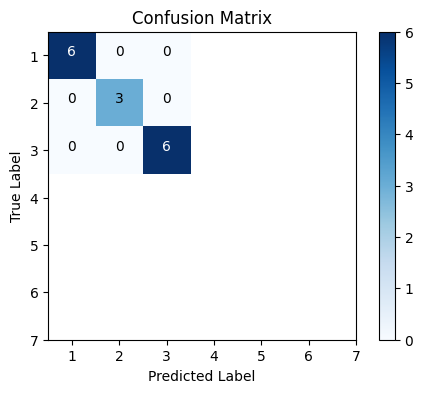

In [4]:
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(1,8)
tick_marks_range = tick_marks - 1
plt.xticks(tick_marks_range, tick_marks)#, rotation=45)
plt.yticks(tick_marks_range, tick_marks)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], 'd'),
                horizontalalignment="center",
                color="white" if conf_mat[i, j] > conf_mat.max() / 2. else "black")
plt.show()